In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# the models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestRegressor #needed for Voting Regressor

In [27]:
# read the file
import os
path = os.getcwd()
fifa_compare = pd.read_csv(path+"/fifa_cleaned.csv")
fifa_compare.head

<bound method NDFrame.head of        sofifa_id         short_name  age  height_cm  weight_kg nationality  \
0         158023           L. Messi   33        170         72   Argentina   
1          20801  Cristiano Ronaldo   35        187         83    Portugal   
2         200389           J. Oblak   27        188         87    Slovenia   
3         188545     R. Lewandowski   31        184         80      Poland   
4         190871          Neymar Jr   28        175         68      Brazil   
...          ...                ...  ...        ...        ...         ...   
18939     256679          K. Angulo   24        176         73    Colombia   
18940     257710     Zhang Mengxuan   21        177         70    China PR   
18941     250989      Wang Zhenghao   20        185         74    China PR   
18942     257697        Chen Zitong   23        186         80    China PR   
18943     257936           Song Yue   28        185         79    China PR   

                                 

In [28]:
# impute the missing values
fifa_compare.isnull().sum()


sofifa_id           0
short_name          0
age                 0
height_cm           0
weight_kg           0
                   ..
high_Work_Rate      0
low_Work_Rate       0
medium_Work_Rate    0
right_foot          0
left_foot           0
Length: 70, dtype: int64

In [29]:
# imputing release_clause_eur with mean value
mean = fifa_compare['release_clause_eur'].mean()
fifa_compare['release_clause_eur'].fillna(mean, inplace = True)

In [30]:
# imputing dribbling with mean value
mean = fifa_compare['dribbling'].mean()
fifa_compare['dribbling'].fillna(mean, inplace = True)

In [31]:
# imputing passing with mean value
mean = fifa_compare['passing'].mean()
fifa_compare['passing'].fillna(mean, inplace = True)


In [32]:
# now for shooting
mean = fifa_compare['shooting'].mean()
fifa_compare['shooting'].fillna(mean, inplace = True)

In [33]:
# same is done for pace
mean = fifa_compare['pace'].mean()
fifa_compare['pace'].fillna(mean, inplace = True)

In [34]:
# same is done for defending
mean = fifa_compare['defending'].mean()
fifa_compare['defending'].fillna(mean, inplace = True)

In [35]:
# same is done for physic
mean = fifa_compare['physic'].mean()
fifa_compare['physic'].fillna(mean, inplace = True)

In [36]:
#dropping columns whcih are not outfield player related
fifa_compare=fifa_compare.drop(['gk_diving','gk_handling','gk_kicking','gk_reflexes',
                                'gk_speed','gk_positioning','defending_marking','goalkeeping_diving',
                               'goalkeeping_handling', 'goalkeeping_kicking','goalkeeping_positioning', 
                                'goalkeeping_reflexes'], axis=1)

<AxesSubplot:>

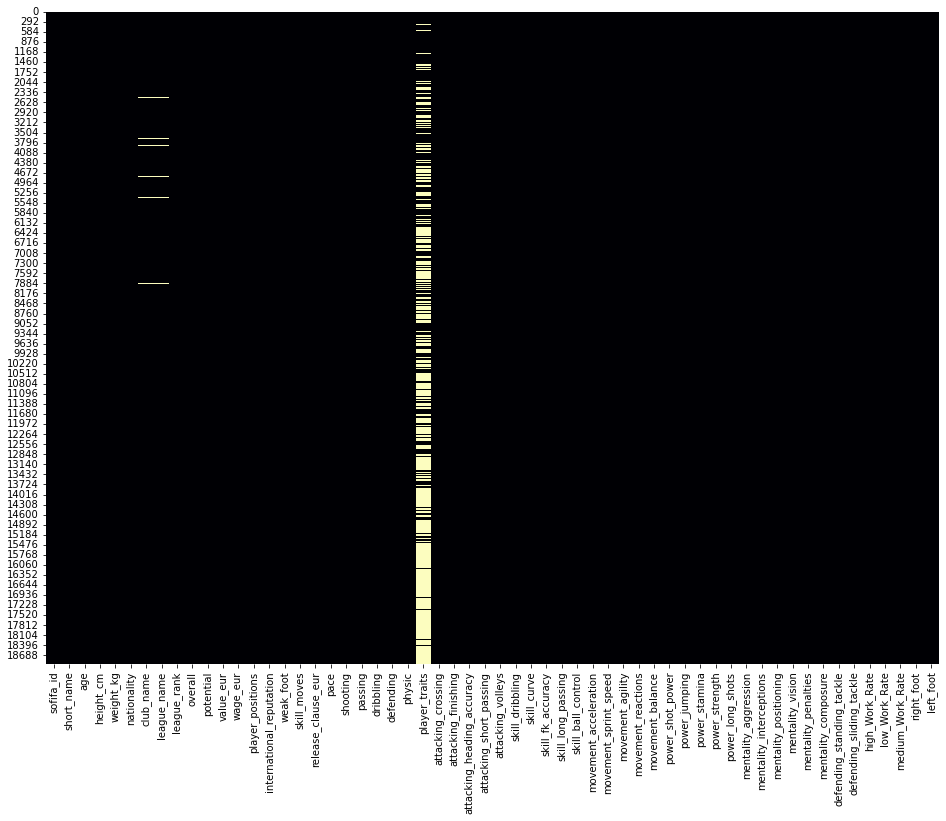

In [37]:
# created a heatmap to check null values in the dataset
plt.figure(figsize = (16,12))
sns.heatmap(fifa_compare.isnull(), cbar=False , cmap = 'magma')

In [38]:
# convert categorical data into numerical data if need be
fifa_compare_dummies = pd.get_dummies(fifa_compare)

In [39]:
# split data into training (80%) and test set (20%)
train, test = train_test_split(fifa_compare_dummies, test_size = 0.2)
# print(test[0:1])

In [ ]:
# save the cleaned data tocsv for future use
#fifa_compare_dummies.to_csv("Datasets/cleaned_dataset.csv")


In [40]:
# identify the data to be trained followed by labels and target (overall)
x_train = train.drop('overall', axis = 1)
y_train = train['overall']


In [41]:
x_test = test.drop('overall', axis = 1)
y_test = test['overall']

In [48]:
# prepare voting regressor weak builders
reg1 = RandomForestRegressor(random_state = 10, n_estimators = 10)
reg2 = LinearRegression()

In [49]:
# prepare gradient boosting regressor parameters
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'squared_error'}

In [50]:
# identifying random seed
random_seed = 10

In [51]:
# preparing the models to use
outcome = []          # results of cross validation
model_names = []      # the name tag of the models
models = []           # tuple mapping for DECLARING the models

In [52]:
# insert the models inside the respective array
models.append(('KNNReg', KNeighborsRegressor(n_neighbors = 9)))
models.append(('MLR', LinearRegression()))
models.append(('VReg', VotingRegressor([ ('rf', reg1), ('lr', reg2) ])))
models.append(('GBR', GradientBoostingRegressor(**params)))


In [53]:
# run the K-fold analysis through a for loop on all models
# and generate mean and standard deviation for all models
for model_name, model in models:
    k_fold_validation = model_selection.KFold(n_splits = 10, random_state = random_seed, shuffle = True)
    results = model_selection.cross_val_score(model, x_test, y_test, cv = k_fold_validation, scoring = 'r2')
    outcome.append(results)
    model_names.append(model_name)
    output_message = "%s| Mean = %f STD = %f Variance = %f" % (model_name, results.mean(), results.std(), results.var())
    print(output_message)

KNNReg| Mean = 0.927724 STD = 0.011160 Variance = 0.000125
MLR| Mean = 0.917350 STD = 0.012339 Variance = 0.000152
VReg| Mean = 0.975438 STD = 0.003530 Variance = 0.000012
GBR| Mean = 0.990831 STD = 0.001853 Variance = 0.000003


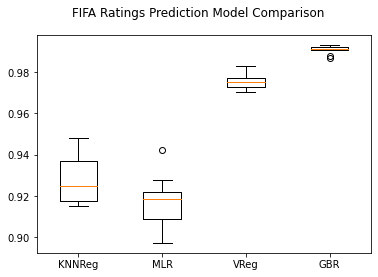

In [54]:
# finally, visualize the analysis
fig = plt.figure()
fig.suptitle('FIFA Ratings Prediction Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show()